In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from pathlib import Path
#from jupyterthemes import jtplot

In [4]:
%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
#jtplot.style(theme='onedork', context='talk', fscale=1.4, spines=False, gridlines='--', ticks=True, grid=False, figsize=(14, 8))


### Load BBC data

In [5]:
path = Path('bbc')
files = path.glob('**/*.txt')
doc_list = []
for i, file in enumerate(files):
    with open(str(file), encoding='latin1') as f:
        _, topic, file_name = file.parts

        lines = f.readlines()
        file_id = file_name.split('.')[0]
        heading = lines[0].strip()
        body = ' '.join([l.strip() for l in lines[1:]])
        doc_list.append([topic, heading, body])

### Convert to DataFrame

In [6]:
docs = pd.DataFrame(doc_list, columns=['topic', 'heading', 'article'])
print(docs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
topic      2225 non-null object
heading    2225 non-null object
article    2225 non-null object
dtypes: object(3)
memory usage: 52.3+ KB
None


In [10]:
docs.head()

,topic,heading,article
0,entertainment,Musicians to tackle US red tape,Musicians' groups are to tackle US visa regul...
1,entertainment,U2's desire to be number one,"U2, who have won three prestigious Grammy Awa..."
2,entertainment,Rocker Doherty in on-stage fight,Rock singer Pete Doherty has been involved in...
3,entertainment,Snicket tops US box office chart,The film adaptation of Lemony Snicket novels ...
4,entertainment,Ocean's Twelve raids box office,"Ocean's Twelve, the crime caper sequel starri..."


### Train-test split

In [7]:
train_docs, test_docs = train_test_split(
    docs, stratify=docs.topic, test_size=50, random_state=42)

In [8]:
train_docs.shape, test_docs.shape

((2175, 3), (50, 3))

In [9]:
pd.Series(test_docs.topic).value_counts()

sport            12
business         11
entertainment     9
politics          9
tech              9
Name: topic, dtype: int64

### Vectorize train & test sets

Vectorization must come before any sort of topic modelling. Typically this is done with a count vectorizor or a TF-IDF vectorizer

In [11]:
vectorizer = CountVectorizer(max_df=.2, min_df=3, stop_words='english', 
                             max_features=2000)
train_dtm = vectorizer.fit_transform(train_docs.article)
words = vectorizer.get_feature_names()
train_dtm

<2175x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 178873 stored elements in Compressed Sparse Row format>

In [12]:
test_dtm = vectorizer.transform(test_docs.article)
test_dtm

<50x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 3890 stored elements in Compressed Sparse Row format>

### Latent Semantic Analysis

In [13]:
svd = TruncatedSVD(n_components=5, n_iter=20, random_state=42)
svd.fit(train_dtm)

TruncatedSVD(algorithm='randomized', n_components=5, n_iter=20, random_state=42,
             tol=0.0)

#### Explore Topics 

In [14]:
topic_labels = ['Topic {}'.format(i) for i in range(1, 6)]

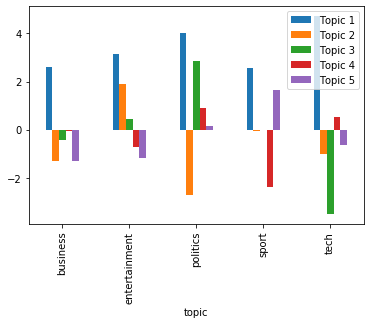

In [15]:
svd_result = pd.DataFrame(data=svd.transform(train_dtm),
                   columns=topic_labels,
                   index=train_docs.topic)
svd_result.groupby(level='topic').mean().plot.bar();

In [16]:
topics = pd.DataFrame(svd.components_.T,
                      index=words,
                      columns=topic_labels)
topics.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
10,0.07,-0.00,-0.01,-0.01,-0.01
100,0.02,-0.01,-0.02,0.01,-0.01
100m,0.00,0.00,0.00,-0.01,-0.00
11,0.03,-0.00,-0.00,-0.02,-0.02
12,0.03,-0.01,-0.02,-0.02,-0.00


In [17]:
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(10).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,music,best,labour,music,music
1,best,music,party,urban,game
2,think,song,best,labour,urban
3,good,25,election,party,games
4,song,awards,blair,election,england
5,game,robbie,brown,black,roddick
6,labour,urban,song,mobile,play
7,british,won,minister,blair,wales
8,games,film,kilroy,stone,black
9,mobile,award,prime,digital,party


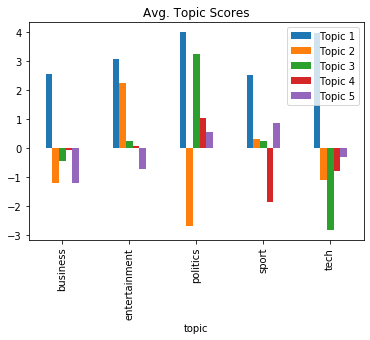

In [18]:
test_eval = pd.DataFrame(data=svd.transform(test_dtm), 
                         columns=topic_labels,
                         index=test_docs.topic)

test_eval.groupby(level='topic').mean().plot.bar(title='Avg. Topic Scores');

### probabilistic Latent Semantic Analysis

#### Equivalent to Non-Negative Matrix Factorization with Kullback-Leibler Divergence objective

In [19]:
nmf = NMF(n_components=5, random_state=42, solver='mu',
          beta_loss='kullback-leibler', max_iter=1000)
nmf.fit(train_dtm)
nmf.reconstruction_err_

1168.6761144034633

In [27]:
#These are the topic scores for that come form the training dataset
nmf.transform(train_dtm)

array([[1.31072872e-01, 4.68121597e-02, 1.84618029e-03, 4.93601750e-06,
        2.42550286e-04],
       [6.00996696e-01, 2.12601316e-10, 2.89064480e-01, 1.07486713e-04,
        3.20986868e-04],
       [4.02339020e-02, 2.52030071e-01, 2.38815281e-02, 2.37368209e-01,
        5.59122813e-05],
       ...,
       [6.71759335e-03, 1.00622937e-02, 1.99416091e-02, 2.61912560e-01,
        2.10140524e-01],
       [1.53468487e-01, 1.32183191e-02, 1.37850306e-02, 3.33880162e-02,
        1.14487531e-05],
       [1.54209172e-01, 5.53392194e-08, 7.53278188e-01, 2.96828239e-03,
        3.40429928e-03]])

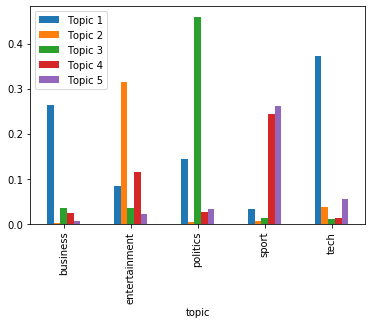

In [20]:
nmf_res = pd.DataFrame(data=nmf.transform(train_dtm),
                   columns=topic_labels,
                   index=train_docs.topic,)
nmf_res.groupby(level='topic').mean().plot.bar();

In [21]:
topics = pd.DataFrame(nmf.components_.T,
                      index=words,
                      columns=topic_labels)
topics.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
10,1.02,0.00,0.00,0.72,0.00
100,0.51,0.00,0.00,0.00,0.00
100m,0.03,0.00,0.00,0.21,0.00
11,0.39,0.00,0.00,0.44,0.00
12,0.48,0.00,0.00,0.50,0.00


In [22]:
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(10).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,market,film,labour,second,game
1,company,best,election,final,england
2,says,music,party,won,games
3,work,awards,blair,win,play
4,use,award,minister,france,players
5,million,won,brown,open,wales
6,firm,band,public,best,club
7,2004,actor,howard,old,good
8,technology,director,britain,ireland,think
9,mobile,album,prime,international,half


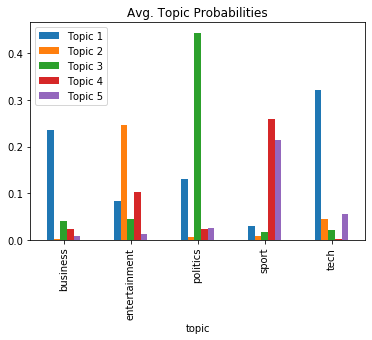

In [23]:
test_eval = pd.DataFrame(data=nmf.transform(test_dtm),
                         columns=topic_labels,
                         index=test_docs.topic)

test_eval.groupby(level='topic').mean().plot.bar(
    title='Avg. Topic Probabilities');

### LDA with sklearn

In [24]:
lda_base = LatentDirichletAllocation(n_components=5, n_jobs=-1, learning_method='batch')
lda_base.fit(train_dtm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=-1,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

#### Persist model

In [28]:
joblib.dump(lda_base, 'lda_10_iter.pkl')

['lda_10_iter.pkl']

In [29]:
lda_base = joblib.load('lda_10_iter.pkl') 
lda_base

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=-1,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

#### Explore topics & word distributions

In [30]:
# pseudo counts
topics_count = lda_base.components_
print(topics_count.shape)
topics_count[:5]

(5, 2000)


array([[ 88.31374366,  41.45239611,   0.20433089, ...,   0.72666043,
          0.48641843,   0.20187424],
       [115.08937746,  75.11044459,   2.32486312, ...,   0.20000522,
          0.200021  ,   0.20002005],
       [196.07723984,  23.27647206,  31.05489744, ...,   0.2000124 ,
          0.20001132,  95.46506044],
       [ 55.59013809,  33.73476294,   6.74794284, ...,   0.20016584,
          0.20014097,   2.92855492],
       [ 89.92950095,  33.4259243 ,  10.6679657 , ...,  58.6731561 ,
        179.91340827,   0.20449035]])

In [31]:
topics_prob = topics_count / topics_count.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T,
                      index=words,
                      columns=topic_labels)
topics.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
10,0.00,0.00,0.00,0.00,0.00
100,0.00,0.00,0.00,0.00,0.00
100m,0.00,0.00,0.00,0.00,0.00
11,0.00,0.00,0.00,0.00,0.00
12,0.00,0.00,0.00,0.00,0.00


In [32]:
# all words have positive probability for all topics
topics[topics.gt(0).all(1)].shape[0] == topics.shape[0]

True

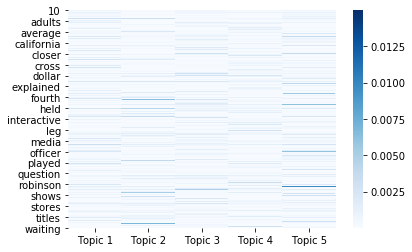

In [33]:
sns.heatmap(topics, cmap='Blues')

This gets the words that are more commonly associated with each topic

In [34]:
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(10).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,economy,technology,best,labour,company
1,economic,mobile,film,party,firm
2,growth,music,game,election,sales
3,china,use,win,blair,market
4,countries,users,won,minister,deal
5,spending,digital,england,public,shares
6,tax,games,play,brown,chief
7,eu,phone,second,prime,group
8,rise,software,old,say,oil
9,budget,tv,good,howard,financial


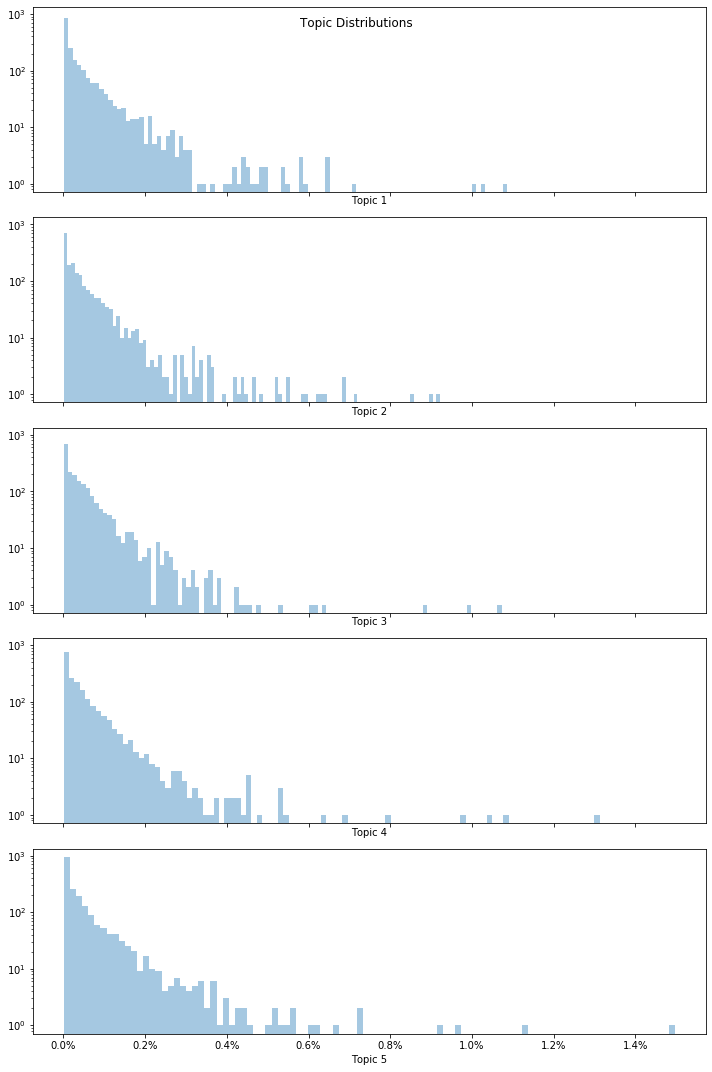

In [35]:
fig, axes = plt.subplots(nrows=5, sharey=True, sharex=True, figsize=(10, 15))
for i, (topic, prob) in enumerate(topics.items()):
    sns.distplot(prob, ax=axes[i], bins=100, kde=False, norm_hist=False)
    axes[i].set_yscale('log')
    axes[i].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
fig.suptitle('Topic Distributions')
fig.tight_layout()

### Evaluate fit

In [36]:
train_preds = lda_base.transform(train_dtm)
train_preds.shape

(2175, 5)

In [37]:
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=train_docs.topic)
train_eval.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
topic,,,,,
entertainment,0.00,0.41,0.07,0.24,0.27
tech,0.07,0.49,0.00,0.44,0.00
entertainment,0.00,0.00,0.95,0.00,0.04
business,0.99,0.00,0.00,0.00,0.00
sport,0.00,0.05,0.94,0.00,0.00


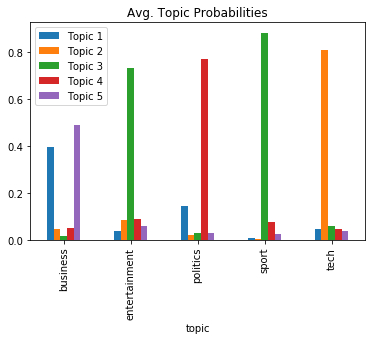

In [38]:
train_eval.groupby(level='topic').mean().plot.bar(title='Avg. Topic Probabilities');

Text(0.5, 1, 'Train Data: Topic Assignments')

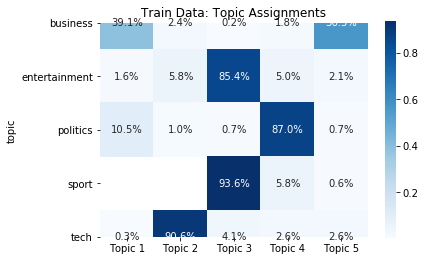

In [39]:
df = train_eval.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True)
sns.heatmap(df.groupby(level='topic').value_counts(normalize=True)
            .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Train Data: Topic Assignments')

### Test Set 

In [41]:
#See what the topic probabilities are for the articles in the test set 
test_preds = lda_base.transform(test_dtm)
test_eval = pd.DataFrame(test_preds, columns=topic_labels, index=test_docs.topic)
test_eval.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
topic,,,,,
entertainment,0.22,0.47,0.06,0.00,0.25
tech,0.00,0.83,0.00,0.16,0.00
tech,0.00,0.70,0.30,0.00,0.00
business,0.18,0.03,0.00,0.00,0.78
sport,0.00,0.00,0.99,0.00,0.00


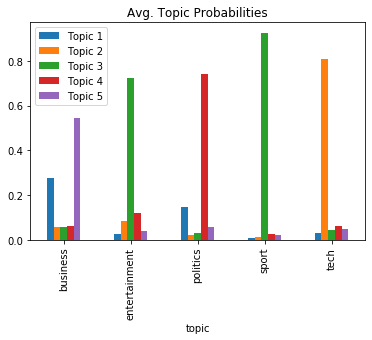

In [42]:
test_eval.groupby(level='topic').mean().plot.bar(title='Avg. Topic Probabilities');

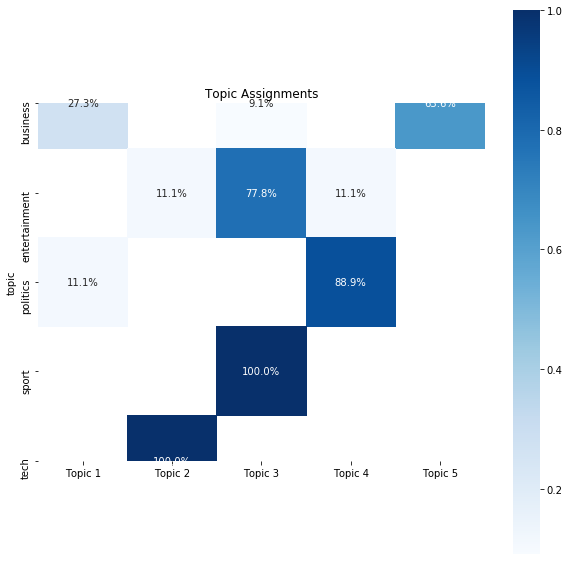

In [47]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

df = test_eval.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True)
sns.heatmap(df.groupby(level='topic').value_counts(normalize=True)
            .unstack(-1), annot=True, fmt='.1%', cmap='Blues',square=True,ax=ax)
plt.title('Topic Assignments');

### Retrain unitl perplexity no longer decreases

In [48]:
lda_opt = LatentDirichletAllocation(n_components=5, n_jobs=-1, max_iter=500,
                                learning_method='batch', evaluate_every=5, 
                                verbose=1, random_state=42)
lda_opt.fit(train_dtm)

iteration: 1 of max_iter: 500
iteration: 2 of max_iter: 500
iteration: 3 of max_iter: 500
iteration: 4 of max_iter: 500
iteration: 5 of max_iter: 500, perplexity: 1093.4541
iteration: 6 of max_iter: 500
iteration: 7 of max_iter: 500
iteration: 8 of max_iter: 500
iteration: 9 of max_iter: 500
iteration: 10 of max_iter: 500, perplexity: 1064.2315
iteration: 11 of max_iter: 500
iteration: 12 of max_iter: 500
iteration: 13 of max_iter: 500
iteration: 14 of max_iter: 500
iteration: 15 of max_iter: 500, perplexity: 1059.5511
iteration: 16 of max_iter: 500
iteration: 17 of max_iter: 500
iteration: 18 of max_iter: 500
iteration: 19 of max_iter: 500
iteration: 20 of max_iter: 500, perplexity: 1058.3663
iteration: 21 of max_iter: 500
iteration: 22 of max_iter: 500
iteration: 23 of max_iter: 500
iteration: 24 of max_iter: 500
iteration: 25 of max_iter: 500, perplexity: 1056.6921
iteration: 26 of max_iter: 500
iteration: 27 of max_iter: 500
iteration: 28 of max_iter: 500
iteration: 29 of max_iter:

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=5, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=500,
                          mean_change_tol=0.001, n_components=5, n_jobs=-1,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=1)

In [52]:
joblib.dump(lda_opt, 'lda_opt.pkl')

['lda_opt.pkl']

In [53]:
train_opt_eval = pd.DataFrame(data=lda_opt.transform(train_dtm),
                          columns=topic_labels,
                          index=train_docs.topic)

In [54]:
test_opt_eval = pd.DataFrame(data=lda_opt.transform(test_dtm),
                         columns=topic_labels, 
                         index=test_docs.topic)

### Compare Train & Test Topic Assignments 

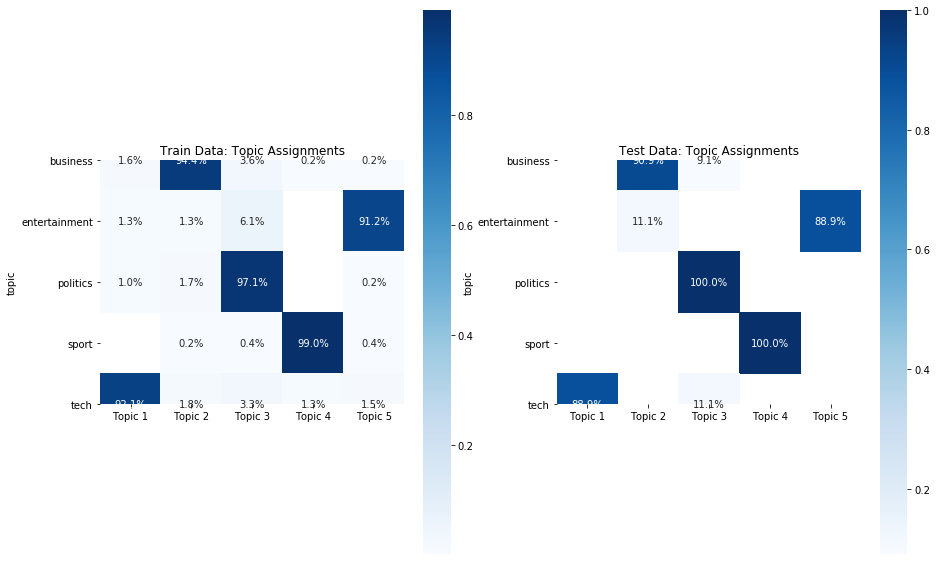

In [56]:
fig, axes = plt.subplots(ncols=2,figsize=(15,10))
source = ['Train', 'Test']
for i, df in enumerate([train_opt_eval, test_opt_eval]):
    df = df.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True)
    sns.heatmap(df.groupby(level='topic').value_counts(normalize=True)
            .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True, ax=axes[i])
    axes[i].set_title('{} Data: Topic Assignments'.format(source[i]));

The LDA has actually done a really good job here - the actual topics from the dataset have 'emerged' and it has classified the topics with decent accuracy. Typically for those documents with more even topic probabilities, this is because there are indeed a few different subjects mentioned

### Explore misclassified articles 

In [57]:
test_assignments = test_opt_eval.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True).to_frame('predicted').reset_index()
test_assignments['heading'] = test_docs.heading.values
test_assignments['article'] = test_docs.article.values
test_assignments.head()

,topic,predicted,heading,article
0,business,Topic 2,German music in a 'zombie' state,The German music business - the third largest...
1,business,Topic 2,Kenyan school turns to handhelds,At the Mbita Point primary school in western ...
2,business,Topic 2,Halo fans' hope for sequel,Xbox video game Halo 2 has been released in t...
3,business,Topic 2,Novartis hits acquisition trail,Swiss drugmaker Novartis has announced 5.65bn...
4,business,Topic 2,Radcliffe will compete in London,Paula Radcliffe will compete in the Flora Lon...


In [58]:
misclassified = test_assignments[(test_assignments.topic == 'sport') & (
    test_assignments.predicted == 'Topic 3')]
misclassified.heading

Series([], Name: heading, dtype: object)

In [59]:
misclassified.article.tolist()

[]